# PyPI Package Download Rate Prediction

This is a quick example of using MindsDB's `lightwood` for training a model based on PyPI's statistics stored on Google's BigQuery. This implementation is based on MindsDB's PyPI Handler.

#### Training

The following SQL query helps you create and train model named `pypi_model` based on your `<PACKAGE-NAME>`.

```sql
CREATE DATABASE pypi_datasource
WITH ENGINE = 'pypi';

CREATE MODEL mindsdb.pypi_model
FROM pypi_datasource
  (SELECT *
FROM pypi_datasource.overall WHERE package="<PACKAGE-NAME>" AND mirrors=true limit 500)
PREDICT downloads;
```

#### Installing the requirements

In [ ]:
!pip install -r requirements.txt

#### Specifieng the required CONSTANT variables

In [5]:
DAYS_TO_BE_PREDICTED = 100
MINDSDB_INSTANCE = "http://127.0.0.1:47334"
PACKAGE_NAME = "requests"

Note: Make sure that your model is trained based on the same `PACKAGE_NAME`.

#### Importing the requirments

In [6]:
from datetime import datetime, timedelta

import mindsdb_sdk
import pandas as pd
import plotly.graph_objects as go

#### Connecting to the MindsDB's instance

In [7]:
server = mindsdb_sdk.connect()
server = mindsdb_sdk.connect(MINDSDB_INSTANCE)

databases = server.list_databases()
database = databases[-1]

### Taking the trained data for _overall plotting_

In [8]:
query = database.query(
    f'SELECT date, downloads FROM pypi_datasource.overall WHERE package="{PACKAGE_NAME}" AND mirrors=true limit 500'
)
overall_df = query.fetch()

### Prediction phase

In [12]:
# an empty dataframe
predicted_df = pd.DataFrame(columns=["date", "downloads"])

today = datetime.today()
current_date = (today - timedelta(days=180)).date()

for i in range(DAYS_TO_BE_PREDICTED):
    query = database.query(
        f'SELECT date, downloads FROM mindsdb.pypi_model WHERE date="{current_date}"'
    )
    predicted_value = query.fetch()
    current_date = (today + timedelta(days=i)).date()
    predicted_df = pd.concat([predicted_df, query.fetch()], ignore_index=True)

Now, our `predicted_df` is filled with the predicted values from 180 days before till the next `DAYS_TO_BE_PREDICTED` days. We have access to both `predicted_df` and `overall_df`. It's time for plotting!

### Plotting

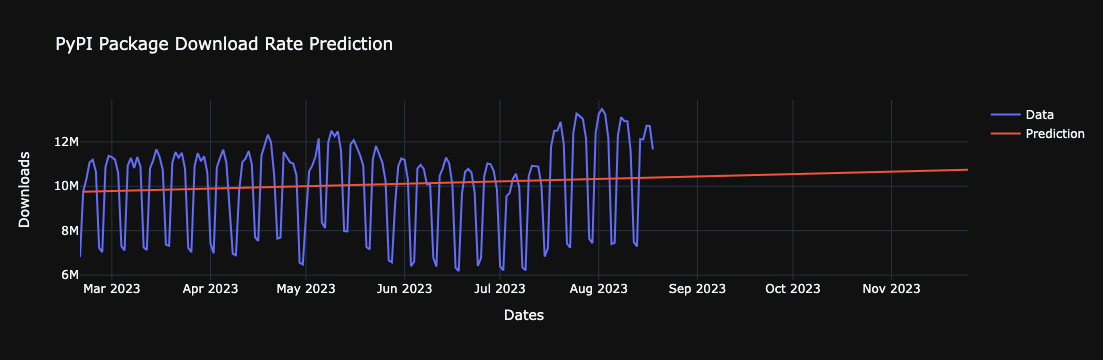

In [15]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=overall_df["date"], y=overall_df["downloads"], mode="lines", name="Data"
    )
)
fig.add_trace(
    go.Scatter(
        x=predicted_df["date"],
        y=predicted_df["downloads"],
        mode="lines",
        name="Prediction",
    )
)
fig.update_layout(
    title="PyPI Package Download Rate Prediction",
    xaxis_title="Dates",
    yaxis_title="Downloads",
    template="plotly_dark",
)

fig.show()

### Useful links

- MindsDB's website: https://mindsdb.com
- MindsDB's PyPI Handler: https://github.com/mindsdb/mindsdb/pull/7026